In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
from seaborn import color_palette
import cv2

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
_BATCH_NORM_DECAY = 0.9
_BATCH_NORM_EPSILON = 1e-05
_LEAKY_RELU = 0.1
_ANCHORS = [(10, 13), (16, 30), (33, 23),
            (30, 61), (62, 45), (59, 119),
            (116, 90), (156, 198), (373, 326)]
_MODEL_SIZE = (416, 416)

def batch_norm(inputs, training, data_format):
    """Performs a batch normalization using a standard set of parameters."""
    return tf.layers.batch_normalization(
        inputs=inputs, axis=1 if data_format == 'channels_first' else 3,
        momentum=_BATCH_NORM_DECAY, epsilon=_BATCH_NORM_EPSILON,
        scale=True, training=training)


def fixed_padding(inputs, kernel_size, data_format):
    """ResNet implementation of fixed padding.
    Pads the input along the spatial dimensions independently of input size.
    Args:
        inputs: Tensor input to be padded.
        kernel_size: The kernel to be used in the conv2d or max_pool2d.
        data_format: The input format.
    Returns:
        A tensor with the same format as the input.
    """
    pad_total = kernel_size - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg

    if data_format == 'channels_first':
        padded_inputs = tf.pad(inputs, [[0, 0], [0, 0],
                                        [pad_beg, pad_end],
                                        [pad_beg, pad_end]])
    else:
        padded_inputs = tf.pad(inputs, [[0, 0], [pad_beg, pad_end],
                                        [pad_beg, pad_end], [0, 0]])
    return padded_inputs


def conv2d_fixed_padding(inputs, filters, kernel_size, data_format, strides=1):
    """Strided 2-D convolution with explicit padding."""
    if strides > 1:
        inputs = fixed_padding(inputs, kernel_size, data_format)

    return tf.layers.conv2d(
        inputs=inputs, filters=filters, kernel_size=kernel_size,
        strides=strides, padding=('SAME' if strides == 1 else 'VALID'),
        use_bias=False, data_format=data_format)


def darknet53_residual_block(inputs, filters, training, data_format,
                             strides=1):
    """Creates a residual block for Darknet."""
    shortcut = inputs

    inputs = conv2d_fixed_padding(
        inputs, filters=filters, kernel_size=1, strides=strides,
        data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(
        inputs, filters=2 * filters, kernel_size=3, strides=strides,
        data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs += shortcut

    return inputs


def darknet53(inputs, training, data_format):
    """Creates Darknet53 model for feature extraction."""
    inputs = conv2d_fixed_padding(inputs, filters=32, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
    inputs = conv2d_fixed_padding(inputs, filters=64, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = darknet53_residual_block(inputs, filters=32, training=training,
                                      data_format=data_format)

    inputs = conv2d_fixed_padding(inputs, filters=128, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    for _ in range(2):
        inputs = darknet53_residual_block(inputs, filters=64,
                                          training=training,
                                          data_format=data_format)

    inputs = conv2d_fixed_padding(inputs, filters=256, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    for _ in range(8):
        inputs = darknet53_residual_block(inputs, filters=128,
                                          training=training,
                                          data_format=data_format)

    route1 = inputs

    inputs = conv2d_fixed_padding(inputs, filters=512, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    for _ in range(8):
        inputs = darknet53_residual_block(inputs, filters=256,
                                          training=training,
                                          data_format=data_format)

    route2 = inputs

    inputs = conv2d_fixed_padding(inputs, filters=1024, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    for _ in range(4):
        inputs = darknet53_residual_block(inputs, filters=512,
                                          training=training,
                                          data_format=data_format)

    return route1, route2, inputs


def yolo_convolution_block(inputs, filters, training, data_format):
    """Creates convolution operations layer used after Darknet."""
    inputs = conv2d_fixed_padding(inputs, filters=filters, kernel_size=1,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(inputs, filters=2 * filters, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(inputs, filters=filters, kernel_size=1,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(inputs, filters=2 * filters, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(inputs, filters=filters, kernel_size=1,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    route = inputs

    inputs = conv2d_fixed_padding(inputs, filters=2 * filters, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    return route, inputs


def yolo_layer(inputs, n_classes, anchors, img_size, data_format):
    """Creates Yolo final detection layer.
    Detects boxes with respect to anchors.
    Args:
        inputs: Tensor input.
        n_classes: Number of labels.
        anchors: A list of anchor sizes.
        img_size: The input size of the model.
        data_format: The input format.
    Returns:
        Tensor output.
    """
    n_anchors = len(anchors)

    inputs = tf.layers.conv2d(inputs, filters=n_anchors * (5 + n_classes),
                              kernel_size=1, strides=1, use_bias=True,
                              data_format=data_format)

    shape = inputs.get_shape().as_list()
    grid_shape = shape[2:4] if data_format == 'channels_first' else shape[1:3]
    if data_format == 'channels_first':
        inputs = tf.transpose(inputs, [0, 2, 3, 1])
    inputs = tf.reshape(inputs, [-1, n_anchors * grid_shape[0] * grid_shape[1],
                                 5 + n_classes])

    strides = (img_size[0] // grid_shape[0], img_size[1] // grid_shape[1])

    box_centers, box_shapes, confidence, classes = \
        tf.split(inputs, [2, 2, 1, n_classes], axis=-1)

    x = tf.range(grid_shape[0], dtype=tf.float32)
    y = tf.range(grid_shape[1], dtype=tf.float32)
    x_offset, y_offset = tf.meshgrid(x, y)
    x_offset = tf.reshape(x_offset, (-1, 1))
    y_offset = tf.reshape(y_offset, (-1, 1))
    x_y_offset = tf.concat([x_offset, y_offset], axis=-1)
    x_y_offset = tf.tile(x_y_offset, [1, n_anchors])
    x_y_offset = tf.reshape(x_y_offset, [1, -1, 2])
    box_centers = tf.nn.sigmoid(box_centers)
    box_centers = (box_centers + x_y_offset) * strides

    anchors = tf.tile(anchors, [grid_shape[0] * grid_shape[1], 1])
    box_shapes = tf.exp(box_shapes) * tf.to_float(anchors)

    confidence = tf.nn.sigmoid(confidence)

    classes = tf.nn.sigmoid(classes)

    inputs = tf.concat([box_centers, box_shapes,
                        confidence, classes], axis=-1)

    return inputs


def upsample(inputs, out_shape, data_format):
    """Upsamples to `out_shape` using nearest neighbor interpolation."""
    if data_format == 'channels_first':
        inputs = tf.transpose(inputs, [0, 2, 3, 1])
        new_height = out_shape[3]
        new_width = out_shape[2]
    else:
        new_height = out_shape[2]
        new_width = out_shape[1]

    inputs = tf.image.resize_nearest_neighbor(inputs, (new_height, new_width))

    if data_format == 'channels_first':
        inputs = tf.transpose(inputs, [0, 3, 1, 2])

    return inputs


def build_boxes(inputs):
    """Computes top left and bottom right points of the boxes."""
    center_x, center_y, width, height, confidence, classes = \
        tf.split(inputs, [1, 1, 1, 1, 1, -1], axis=-1)

    top_left_x = center_x - width / 2
    top_left_y = center_y - height / 2
    bottom_right_x = center_x + width / 2
    bottom_right_y = center_y + height / 2

    boxes = tf.concat([top_left_x, top_left_y,
                       bottom_right_x, bottom_right_y,
                       confidence, classes], axis=-1)

    return boxes


def non_max_suppression(inputs, n_classes, max_output_size, iou_threshold,
                        confidence_threshold):
    """Performs non-max suppression separately for each class.
    Args:
        inputs: Tensor input.
        n_classes: Number of classes.
        max_output_size: Max number of boxes to be selected for each class.
        iou_threshold: Threshold for the IOU.
        confidence_threshold: Threshold for the confidence score.
    Returns:
        A list containing class-to-boxes dictionaries
            for each sample in the batch.
    """
    batch = tf.unstack(inputs)
    boxes_dicts = []
    for boxes in batch:
        boxes = tf.boolean_mask(boxes, boxes[:, 4] > confidence_threshold)
        classes = tf.argmax(boxes[:, 5:], axis=-1)
        classes = tf.expand_dims(tf.to_float(classes), axis=-1)
        boxes = tf.concat([boxes[:, :5], classes], axis=-1)

        boxes_dict = dict()
        for cls in range(n_classes):
            mask = tf.equal(boxes[:, 5], cls)
            mask_shape = mask.get_shape()
            if mask_shape.ndims != 0:
                class_boxes = tf.boolean_mask(boxes, mask)
                boxes_coords, boxes_conf_scores, _ = tf.split(class_boxes,
                                                              [4, 1, -1],
                                                              axis=-1)
                boxes_conf_scores = tf.reshape(boxes_conf_scores, [-1])
                indices = tf.image.non_max_suppression(boxes_coords,
                                                       boxes_conf_scores,
                                                       max_output_size,
                                                       iou_threshold)
                class_boxes = tf.gather(class_boxes, indices)
                boxes_dict[cls] = class_boxes[:, :5]

        boxes_dicts.append(boxes_dict)

    return boxes_dicts


class Yolo_v3:
    """Yolo v3 model class."""

    def __init__(self, n_classes, model_size, max_output_size, iou_threshold,
                 confidence_threshold, data_format=None):
        """Creates the model.
        Args:
            n_classes: Number of class labels.
            model_size: The input size of the model.
            max_output_size: Max number of boxes to be selected for each class.
            iou_threshold: Threshold for the IOU.
            confidence_threshold: Threshold for the confidence score.
            data_format: The input format.
        Returns:
            None.
        """
        if not data_format:
            if tf.test.is_built_with_cuda():
                data_format = 'channels_first'
            else:
                data_format = 'channels_last'

        self.n_classes = n_classes
        self.model_size = model_size
        self.max_output_size = max_output_size
        self.iou_threshold = iou_threshold
        self.confidence_threshold = confidence_threshold
        self.data_format = data_format

    def __call__(self, inputs, training):
        """Add operations to detect boxes for a batch of input images.
        Args:
            inputs: A Tensor representing a batch of input images.
            training: A boolean, whether to use in training or inference mode.
        Returns:
            A list containing class-to-boxes dictionaries
                for each sample in the batch.
        """
        with tf.variable_scope('yolo_v3_model'):
            if self.data_format == 'channels_first':
                inputs = tf.transpose(inputs, [0, 3, 1, 2])

            inputs = inputs / 255

            route1, route2, inputs = darknet53(inputs, training=training,
                                               data_format=self.data_format)

            route, inputs = yolo_convolution_block(
                inputs, filters=512, training=training,
                data_format=self.data_format)
            detect1 = yolo_layer(inputs, n_classes=self.n_classes,
                                 anchors=_ANCHORS[6:9],
                                 img_size=self.model_size,
                                 data_format=self.data_format)

            inputs = conv2d_fixed_padding(route, filters=256, kernel_size=1,
                                          data_format=self.data_format)
            inputs = batch_norm(inputs, training=training,
                                data_format=self.data_format)
            inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
            upsample_size = route2.get_shape().as_list()
            inputs = upsample(inputs, out_shape=upsample_size,
                              data_format=self.data_format)
            axis = 1 if self.data_format == 'channels_first' else 3
            inputs = tf.concat([inputs, route2], axis=axis)
            route, inputs = yolo_convolution_block(
                inputs, filters=256, training=training,
                data_format=self.data_format)
            detect2 = yolo_layer(inputs, n_classes=self.n_classes,
                                 anchors=_ANCHORS[3:6],
                                 img_size=self.model_size,
                                 data_format=self.data_format)

            inputs = conv2d_fixed_padding(route, filters=128, kernel_size=1,
                                          data_format=self.data_format)
            inputs = batch_norm(inputs, training=training,
                                data_format=self.data_format)
            inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
            upsample_size = route1.get_shape().as_list()
            inputs = upsample(inputs, out_shape=upsample_size,
                              data_format=self.data_format)
            inputs = tf.concat([inputs, route1], axis=axis)
            route, inputs = yolo_convolution_block(
                inputs, filters=128, training=training,
                data_format=self.data_format)
            detect3 = yolo_layer(inputs, n_classes=self.n_classes,
                                 anchors=_ANCHORS[0:3],
                                 img_size=self.model_size,
                                 data_format=self.data_format)

            inputs = tf.concat([detect1, detect2, detect3], axis=1)

            inputs = build_boxes(inputs)

            boxes_dicts = non_max_suppression(
                inputs, n_classes=self.n_classes,
                max_output_size=self.max_output_size,
                iou_threshold=self.iou_threshold,
                confidence_threshold=self.confidence_threshold)

            return boxes_dicts

In [ ]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from seaborn import color_palette
import cv2


def load_images(img_names, model_size):
    """Loads images in a 4D array.
    Args:
        img_names: A list of images names.
        model_size: The input size of the model.
        data_format: A format for the array returned
            ('channels_first' or 'channels_last').
    Returns:
        A 4D NumPy array.
    """
    imgs = []

    for img_name in img_names:
        img = Image.open(img_name)
        img = img.resize(size=model_size)
        img = np.array(img, dtype=np.float32)
        img = np.expand_dims(img[:, :, :3], axis=0)
        imgs.append(img)

    imgs = np.concatenate(imgs)

    return imgs


def load_class_names(file_name):
    """Returns a list of class names read from `file_name`."""
    with open(file_name, 'r') as f:
        class_names = f.read().splitlines()
    return class_names


def draw_boxes(img_names, boxes_dicts, class_names, model_size):
    """Draws detected boxes.
    Args:
        img_names: A list of input images names.
        boxes_dict: A class-to-boxes dictionary.
        class_names: A class names list.
        model_size: The input size of the model.
    Returns:
        None.
    """
    colors = ((np.array(color_palette("hls", 80)) * 255)).astype(np.uint8)
    for num, img_name, boxes_dict in zip(range(len(img_names)), img_names,
                                         boxes_dicts):
        img = Image.open(img_name)
        draw = ImageDraw.Draw(img)
        font = ImageFont.truetype(font='/content/futur.ttf',
                                  size=(img.size[0] + img.size[1]) // 100)
        resize_factor = \
            (img.size[0] / model_size[0], img.size[1] / model_size[1])
        for cls in range(len(class_names)):
            boxes = boxes_dict[cls]
            if np.size(boxes) != 0:
                color = colors[cls]
                for box in boxes:
                    xy, confidence = box[:4], box[4]
                    xy = [xy[i] * resize_factor[i % 2] for i in range(4)]
                    x0, y0 = xy[0], xy[1]
                    thickness = (img.size[0] + img.size[1]) // 200
                    for t in np.linspace(0, 1, thickness):
                        xy[0], xy[1] = xy[0] + t, xy[1] + t
                        xy[2], xy[3] = xy[2] - t, xy[3] - t
                        draw.rectangle(xy, outline=tuple(color))
                    text = '{} {:.1f}%'.format(class_names[cls],
                                               confidence * 100)
                    text_size = draw.textsize(text, font=font)
                    draw.rectangle(
                        [x0, y0 - text_size[1], x0 + text_size[0], y0],
                        fill=tuple(color))
                    draw.text((x0, y0 - text_size[1]), text, fill='black',
                              font=font)
                    print('{} {:.2f}%'.format(class_names[cls],
                                              confidence * 100))

        rgb_img = img.convert('RGB')
        rgb_img.save('Result.jpg')


def draw_frame(frame, frame_size, boxes_dicts, class_names, model_size):
    """Draws detected boxes in a video frame.
    Args:
        frame: A video frame.
        frame_size: A tuple of (frame width, frame height).
        boxes_dicts: A class-to-boxes dictionary.
        class_names: A class names list.
        model_size:The input size of the model.
    Returns:
        None.
    """
    boxes_dict = boxes_dicts[0]
    resize_factor = (frame_size[0] / model_size[1], frame_size[1] / model_size[0])
    colors = ((np.array(color_palette("hls", 80)) * 255)).astype(np.uint8)
    for cls in range(len(class_names)):
        boxes = boxes_dict[cls]
        color = colors[cls]
        color = tuple([int(x) for x in color])
        if np.size(boxes) != 0:
            for box in boxes:
                xy = box[:4]
                xy = [int(xy[i] * resize_factor[i % 2]) for i in range(4)]
                cv2.rectangle(frame, (xy[0], xy[1]), (xy[2], xy[3]), color[::-1], 2)
                (test_width, text_height), baseline = cv2.getTextSize(class_names[cls],
                                                                      cv2.FONT_HERSHEY_SIMPLEX,
                                                                      0.75, 1)
                cv2.rectangle(frame, (xy[0], xy[1]),
                              (xy[0] + test_width, xy[1] - text_height - baseline),
                              color[::-1], thickness=cv2.FILLED)
                cv2.putText(frame, class_names[cls], (xy[0], xy[1] - baseline),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 0), 1)

In [ ]:
def load_weights(variables, file_name):
    """Reshapes and loads official pretrained Yolo weights.
    Args:
        variables: A list of tf.Variable to be assigned.
        file_name: A name of a file containing weights.
    Returns:
        A list of assign operations.
    """
    with open(file_name, "rb") as f:
        # Skip first 5 values containing irrelevant info
        np.fromfile(f, dtype=np.int32, count=5)
        weights = np.fromfile(f, dtype=np.float32)

        assign_ops = []
        ptr = 0

        # Load weights for Darknet part.
        # Each convolution layer has batch normalization.
        for i in range(52):
            conv_var = variables[5 * i]
            gamma, beta, mean, variance = variables[5 * i + 1:5 * i + 5]
            batch_norm_vars = [beta, gamma, mean, variance]

            for var in batch_norm_vars:
                shape = var.shape.as_list()
                num_params = np.prod(shape)
                var_weights = weights[ptr:ptr + num_params].reshape(shape)
                ptr += num_params
                assign_ops.append(tf.assign(var, var_weights))

            shape = conv_var.shape.as_list()
            num_params = np.prod(shape)
            var_weights = weights[ptr:ptr + num_params].reshape(
                (shape[3], shape[2], shape[0], shape[1]))
            var_weights = np.transpose(var_weights, (2, 3, 1, 0))
            ptr += num_params
            assign_ops.append(tf.assign(conv_var, var_weights))

        # Loading weights for Yolo part.
        # 7th, 15th and 23rd convolution layer has biases and no batch norm.
        ranges = [range(0, 6), range(6, 13), range(13, 20)]
        unnormalized = [6, 13, 20]
        for j in range(3):
            for i in ranges[j]:
                current = 52 * 5 + 5 * i + j * 2
                conv_var = variables[current]
                gamma, beta, mean, variance =  \
                    variables[current + 1:current + 5]
                batch_norm_vars = [beta, gamma, mean, variance]

                for var in batch_norm_vars:
                    shape = var.shape.as_list()
                    num_params = np.prod(shape)
                    var_weights = weights[ptr:ptr + num_params].reshape(shape)
                    ptr += num_params
                    assign_ops.append(tf.assign(var, var_weights))

                shape = conv_var.shape.as_list()
                num_params = np.prod(shape)
                var_weights = weights[ptr:ptr + num_params].reshape(
                    (shape[3], shape[2], shape[0], shape[1]))
                var_weights = np.transpose(var_weights, (2, 3, 1, 0))
                ptr += num_params
                assign_ops.append(tf.assign(conv_var, var_weights))

            bias = variables[52 * 5 + unnormalized[j] * 5 + j * 2 + 1]
            shape = bias.shape.as_list()
            num_params = np.prod(shape)
            var_weights = weights[ptr:ptr + num_params].reshape(shape)
            ptr += num_params
            assign_ops.append(tf.assign(bias, var_weights))

            conv_var = variables[52 * 5 + unnormalized[j] * 5 + j * 2]
            shape = conv_var.shape.as_list()
            num_params = np.prod(shape)
            var_weights = weights[ptr:ptr + num_params].reshape(
                (shape[3], shape[2], shape[0], shape[1]))
            var_weights = np.transpose(var_weights, (2, 3, 1, 0))
            ptr += num_params
            assign_ops.append(tf.assign(conv_var, var_weights))

    return assign_ops

In [ ]:
_MODEL_SIZE = (416, 416)
_CLASS_NAMES_FILE = '/content/coco.names.txt'
_MAX_OUTPUT_SIZE = 20


def main(type, iou_threshold, confidence_threshold, input_names):
    class_names = load_class_names(_CLASS_NAMES_FILE)
    n_classes = len(class_names)

    model = Yolo_v3(n_classes=n_classes, model_size=_MODEL_SIZE,
                    max_output_size=_MAX_OUTPUT_SIZE,
                    iou_threshold=iou_threshold,
                    confidence_threshold=confidence_threshold)

    if type == 'images':
        batch_size = len(input_names)
        batch = load_images(input_names, model_size=_MODEL_SIZE)
        inputs = tf.placeholder(tf.float32, [batch_size, *_MODEL_SIZE, 3])
        detections = model(inputs, training=False)
        saver = tf.train.Saver(tf.global_variables(scope='yolo_v3_model'))

        with tf.Session() as sess:
            saver.restore(sess, './weights/model.ckpt')
            detection_result = sess.run(detections, feed_dict={inputs: batch})

        draw_boxes(input_names, detection_result, class_names, _MODEL_SIZE)

        print('Detections have been saved successfully.')

    elif type == 'video':
        inputs = tf.placeholder(tf.float32, [1, *_MODEL_SIZE, 3])
        detections = model(inputs, training=False)
        saver = tf.train.Saver(tf.global_variables(scope='yolo_v3_model'))

        with tf.Session() as sess:
            saver.restore(sess, './weights/model.ckpt')

            win_name = 'Video detection'
            cv2.namedWindow(win_name)
            cap = cv2.VideoCapture(input_names[0])
            frame_size = (cap.get(cv2.CAP_PROP_FRAME_WIDTH),
                          cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fourcc = cv2.VideoWriter_fourcc(*'X264')
            fps = cap.get(cv2.CAP_PROP_FPS)
            out = cv2.VideoWriter('./detections/detections.mp4', fourcc, fps,
                                  (int(frame_size[0]), int(frame_size[1])))

            try:
                while True:
                    ret, frame = cap.read()
                    if not ret:
                        break
                    resized_frame = cv2.resize(frame, dsize=_MODEL_SIZE[::-1],
                                               interpolation=cv2.INTER_NEAREST)
                    detection_result = sess.run(detections,
                                                feed_dict={inputs: [resized_frame]})

                    draw_frame(frame, frame_size, detection_result,
                               class_names, _MODEL_SIZE)

                    cv2.imshow(win_name, frame)

                    key = cv2.waitKey(1) & 0xFF

                    if key == ord('q'):
                        break

                    out.write(frame)
            finally:
                cv2.destroyAllWindows()
                cap.release()
                print('Detections have been saved successfully.')

    else:
        raise ValueError("Inappropriate data type. Please choose either 'video' or 'images'.")

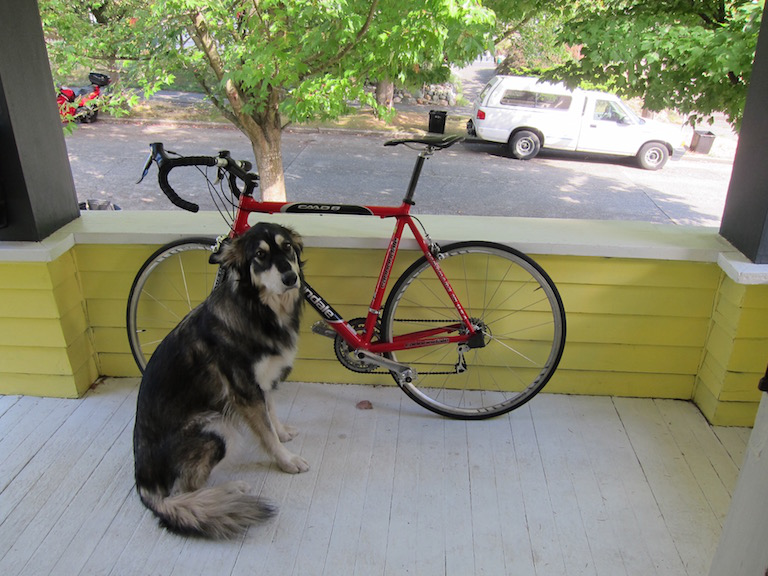

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:575: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:463: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__ca

Instructions for updating:
Use `tf.cast` instead.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:188: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.


bicycle 99.01%
truck 99.86%
dog 99.99%


In [ ]:
img_names = ['/content/dog.jpg']
for img in img_names: display(Image.open(img))

batch_size = len(img_names)
batch = load_images(img_names, model_size=_MODEL_SIZE)
class_names = load_class_names('/content/coco.names.txt')
n_classes = len(class_names)
max_output_size = 10
iou_threshold = 0.5
confidence_threshold = 0.5

model = Yolo_v3(n_classes=n_classes, model_size=_MODEL_SIZE,
                max_output_size=max_output_size,
                iou_threshold=iou_threshold,
                confidence_threshold=confidence_threshold,data_format = 'channels_last')

inputs = tf.placeholder(tf.float32, [batch_size, 416, 416, 3])

detections = model(inputs, training=False)

model_vars = tf.global_variables(scope='yolo_v3_model')
assign_ops = load_weights(model_vars, '/content/yolov3.weights')

with tf.Session() as sess:
    sess.run(assign_ops)
    detection_result = sess.run(detections, feed_dict={inputs: batch})
draw_boxes(img_names, detection_result, class_names, _MODEL_SIZE)

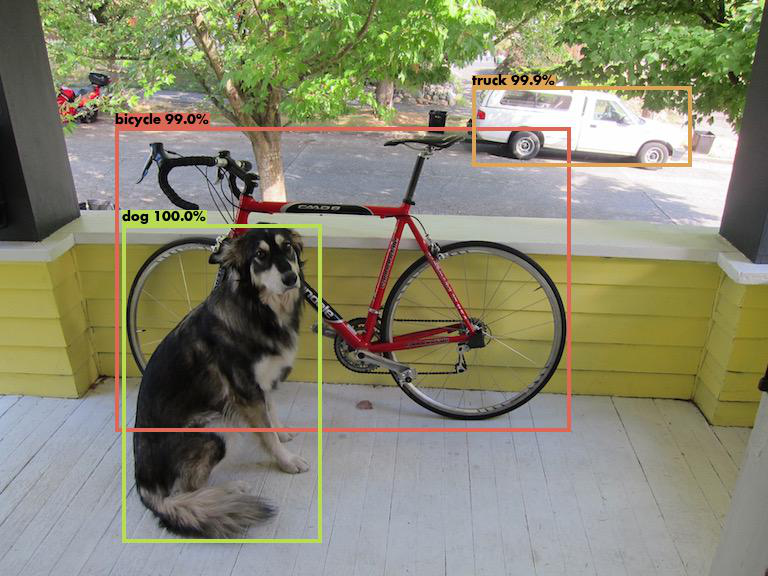

In [ ]:
display(Image.open('/content/Result.jpg'))